In [1]:
# Test MPC

# Standard imports for SCP via JAX and CVXPY
import numpy as np # CVXPY uses numpy
import cvxpy as cvx # For Convex Optimization
from cvxpy.constraints import constraint
import jax # For computing gradients and JIT
import jax.numpy as jnp
from tqdm import tqdm # For progress bars
from functools import partial # For helping JAX

# Assessment
import time
import matplotlib.pyplot as plt
import scipy.interpolate
import scipy.optimize

import dynamics as dn
import control as ct

## Common Parameters

In [2]:
import pykep
# SPACECRAFT PARAMETERS
C_D = 1.5 # Dimensionless
C_SRP = 1.5 # Dimensionless

A = 1.0   # m^2
MASS_SAT = 100   # kg

GAMMA_SRP = C_SRP * A / MASS_SAT
GAMMA_DRAG = C_D * A / MASS_SAT

PSI = 0    # thermal oscillation

R_EARTH = 6378
MU_EARTH_KM = pykep.MU_EARTH * 1e-9
EARTH_TO_SUN_VEC = dn.compute_earth_to_sun()


## Spacecraft Initial States

In [3]:
# Initial condition of reference orbit
h = 300  # km  height for perigee
e = 0.001
a = (R_EARTH + h) / (1 - e)
i = 0.6
W = 0
w = 0
E = 0

# satellite initial condition
# dr = np.array([1.2e-5, 1.5e-5, 1.3e-5])   # relative position vector to ref
# dv = np.array([1.1e-5, 1.4e-5, 1.7e-5])  # relative velocity to ref

dr = np.array([0.1, 0, 0])   # relative position vector to ref
dv = np.array([1e-5, 0, 0])  # relative velocity to ref

# orbital period
T = 2 * jnp.pi * jnp.sqrt(a**3/MU_EARTH_KM)

# compute orbit elements
oe_chief = np.array([a, e, i, W, w, E])
r0_chief, v0_chief = pykep.core.par2ic(oe_chief, MU_EARTH_KM)
r0_sat, v0_sat = r0_chief + dr, v0_chief + dv

# convert to JAX array
x0_chief_eci = jnp.array(np.hstack([r0_chief, v0_chief]))
x0_sat_eci = jnp.array(np.hstack([r0_sat, v0_sat]))

# Initial  States
s0_rel_sat = jnp.hstack([dn.eci_to_lvlh(x0_chief_eci, x0_sat_eci)])
print(f"Should be small but not zero = {s0_rel_sat}")
s0_rel_chief = jnp.hstack([dn.eci_to_lvlh(x0_chief_eci, x0_chief_eci)])
print(f"Should be uniformly zero = {s0_rel_chief}")

Should be small but not zero = [ 1.00097656e-01  0.00000000e+00  0.00000000e+00  9.99999975e-06
 -1.15861782e-04 -1.15915871e-12]
Should be uniformly zero = [0. 0. 0. 0. 0. 0.]


## Time Propagation Settings

In [4]:
# Propagation time settings
dt = 0.1
tspan_quarter_periods = np.arange(0, 0.1 * T, dt)   # propagation step
print(f"Tspan size: {tspan_quarter_periods.size}")

Tspan size: 5440


## JIT Dynamics Functions

In [5]:
# JIT the dynamics functions
t = 0  # we can assume this because there is no change in the parameters
fd_absolute = jax.jit(ct.discretize(ct.absolute_dynamics, dt))

x_chief_eci_traj = ct.propagate_absolute_from_control(x0_chief_eci, ct.zero_control, tspan_quarter_periods, fd_absolute)

interp_abs_chief_jit = jax.jit(ct.interp_fixed(tspan_quarter_periods, x_chief_eci_traj[:, :-1]))
fd_relative_4T = jax.jit(ct.discretize(ct.relative_dynamics, dt, params=(GAMMA_SRP, GAMMA_DRAG, PSI), state_eci_ref_func=interp_abs_chief_jit))
fd_relative_4T_back = jax.jit(ct.discretize(ct.relative_dynamics, -dt, params=(GAMMA_SRP, GAMMA_DRAG, PSI), state_eci_ref_func=interp_abs_chief_jit))

## Generate Initial Condition by back propagation

Initial Condition: [-3.3460601e-06  5.0858202e-05 -1.3439862e-05  1.9396559e-06
 -3.5335900e-06  1.9674803e-06]
(101,)


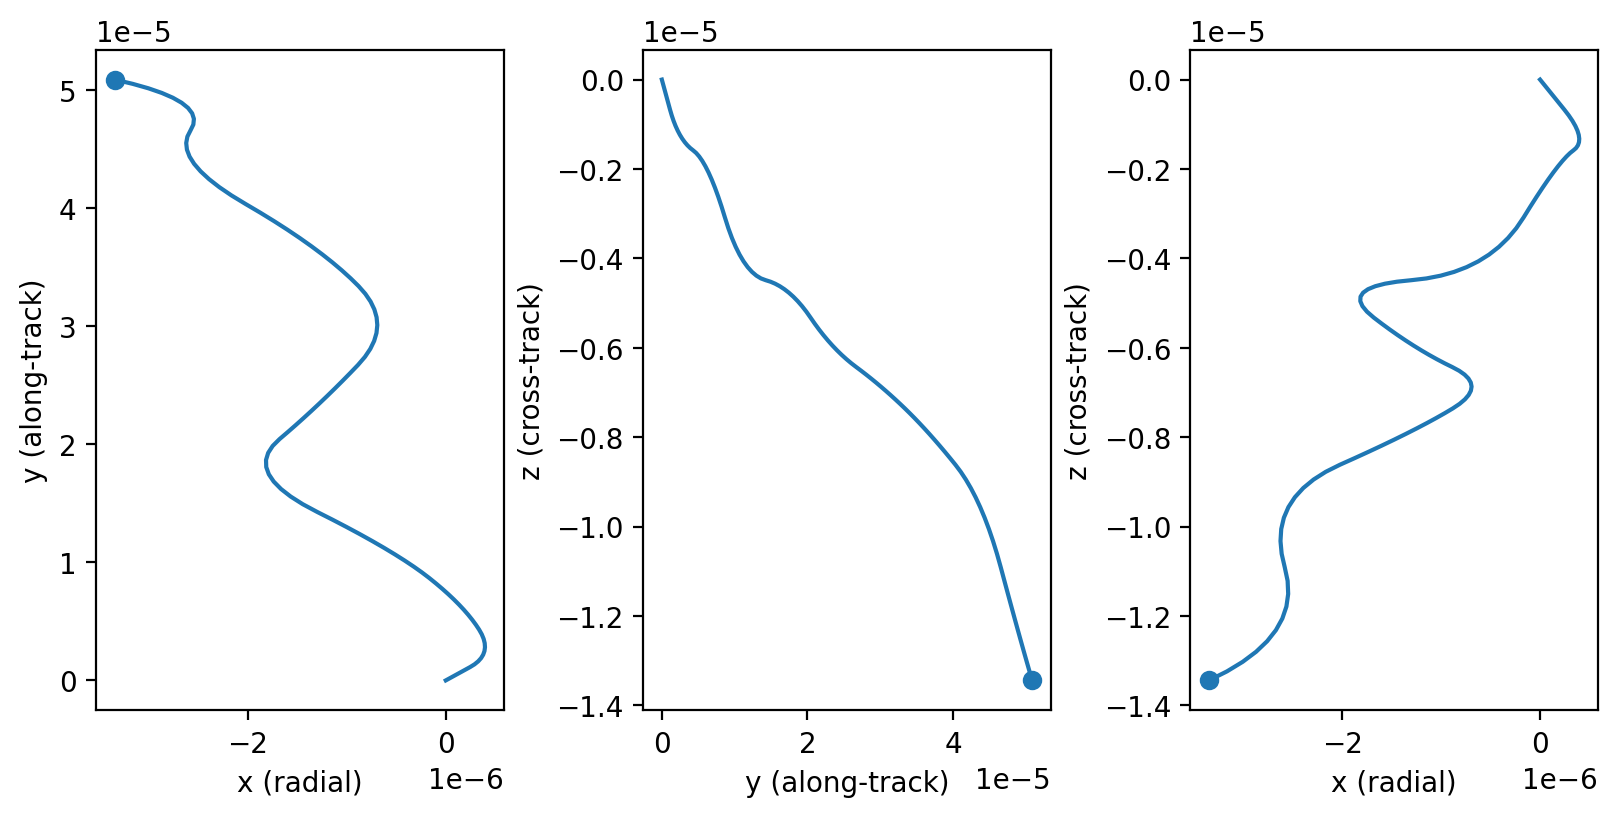

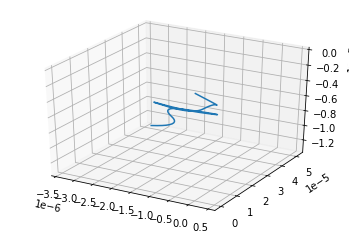

In [6]:
Nctrl = 10  # control steps
control_interval = 10   # apply same ctrl for this step
Nsteps = Nctrl * control_interval

if dt * Nctrl >= tspan_quarter_periods[-1]:
    print("Final Epoch too large!")

t_final = dt * Nsteps

# define control bounds
min_T = -250e-3  # N
max_T = 250e-3 # N

u_min = min_T/MASS_SAT  # m / s
u_max = max_T/MASS_SAT  # m / s

# propagate the state backwards
u_random = ct.rand_box_control(np.ones(Nctrl), u_min, u_max).transpose()  # T x 3
u_mat_rep = np.repeat(u_random, control_interval, axis=0)   # (intervalxT) x 3
u_random_rep = u_mat_rep.flatten()

state_init = np.zeros(6)
states_feasible = np.zeros((6, Nsteps+1))

states_feasible[:,-1] = state_init

for i in range(Nsteps):
    current_t = dt * (Nsteps-i)
    state_init = fd_relative_4T_back(state_init, current_t, u_mat_rep[Nsteps-1-i, :])
    states_feasible[:, Nsteps-1-i] = state_init

print("Initial Condition:", state_init)
ct.plot_control_trajectory(states_feasible)

(101,)


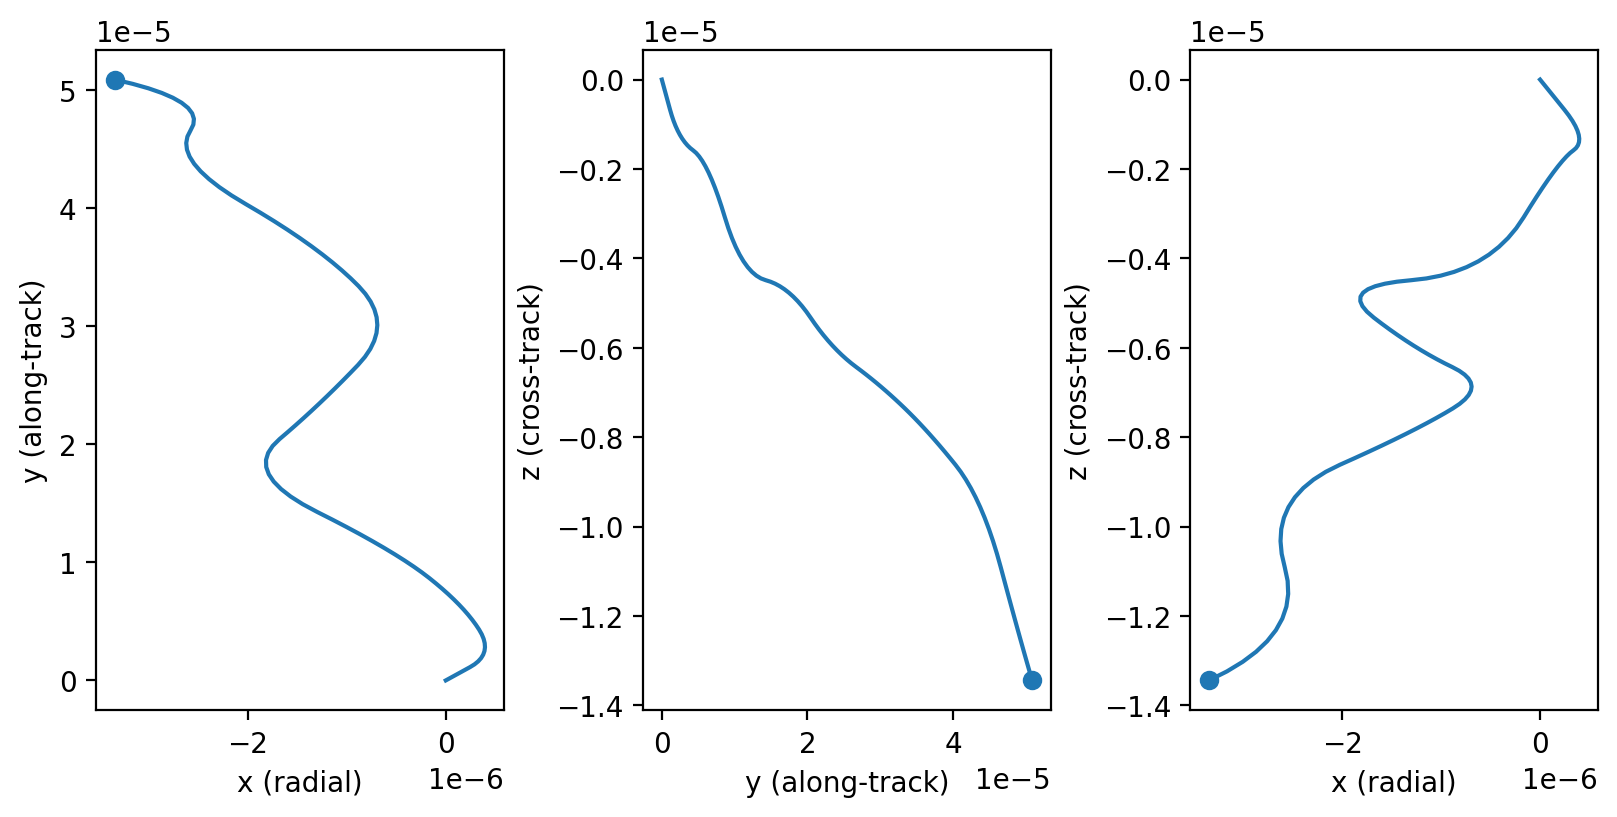

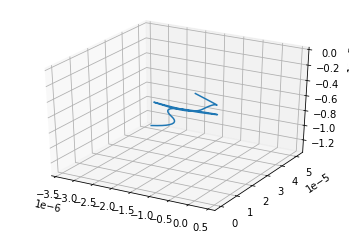

In [7]:
# Forward Propagate the trajectory
t_prop = np.arange(0, t_final, dt)
s_forward = ct.propagate_relative_from_control(state_init, u_random_rep, t_prop,  fd_relative_4T)
ct.plot_control_trajectory(s_forward)

## Test Scipy Optimize

In [11]:
# Test optimizing with scipy minimize

# tspan_optimize, u_optimal, u_initial, cost, constraint_v \
#   = ct.shooting_with_scipy(N_horizon, dt, u_min, u_max, s0_rel_sat, fd_relative_4T,maxiter=500)
# print("Objective Value: ", cost)
# print("Constraint Violation: ", constraint_v)

tspan_optimize, u_optimal, u_initial \
  = ct.optimize_with_scipy(Nctrl, control_interval,
                           dt, u_min, u_max, state_init, fd_relative_4T,
                           u_guess= None, #u_random.flatten(),
                           use_MBH = False,
                           maxiter=5000, stage_w=0, terminal_w=1e10)
print("Finished!")

Lower bound = -0.0025, Upper bound = 0.0025
T start = 0.0, T end = 9.9
U example shape = (30,)
initial cost is 5197575.556942124
Zero u cost is  5197575.556942124
Min u cost is   401601000.6098299
Max u cost is   583772534.6566958
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.19758D+06    |proj g|=  2.50000D-03

At iterate    1    f=  9.44821D+05    |proj g|=  2.73937D-03

At iterate    2    f=  4.28003D+05    |proj g|=  2.86738D-03

At iterate    3    f=  4.18279D+05    |proj g|=  2.77723D-03

At iterate    4    f=  4.02765D+05    |proj g|=  2.72942D-03

At iterate    5    f=  3.72063D+05    |proj g|=  2.64654D-03

At iterate    6    f=  1.99822D+05    |proj g|=  2.88304D-03

At iterate    7    f=  1.07307D+05    |proj g|=  3.43274D-03

At iterate    8    f=  1.97987D+04    |proj g|=  5.00000D-03

At iterate    9    f=  1.51627D+04    |proj


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.




At iterate   43    f=  1.59101D-01    |proj g|=  4.99999D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     43    104    102     0    30   5.000D-03   1.591D-01
  F =  0.15910098351620855     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


Result

Wall time = 8.931439876556396 seconds
final cost: 0.15910098351620855
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
result iters: nit = 43 with nfev = 3193
status: 0
Finished!



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


## Plot control results
- plot the outputs from the control sequence

(100, 3)
(100,)


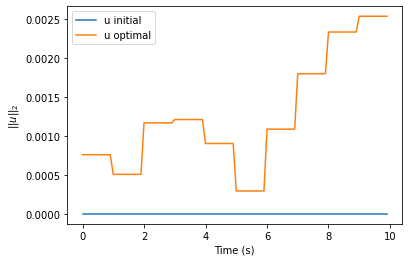

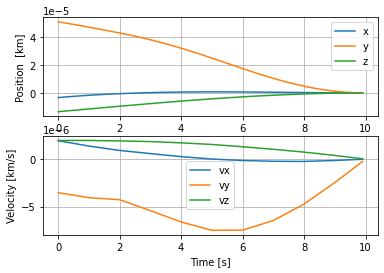

In [12]:
# Plot Result
print(u_optimal.reshape(-1, 3).shape)
print(tspan_optimize.shape)

u_optimal_mat = u_optimal.reshape(-1, 3)
s_optimal = ct.propagate_relative_from_control(state_init, u_optimal, tspan_optimize, fd_relative_4T)
s_init = ct.propagate_relative_from_control(state_init, u_initial, tspan_optimize, fd_relative_4T)

plt.plot(tspan_optimize, np.linalg.norm(u_initial.reshape(-1, 3), axis=1), label="u initial")
plt.plot(tspan_optimize, np.linalg.norm(u_optimal_mat, axis=1), label="u optimal")
# plt.plot(tspan_optimize, np.linalg.norm(u_feasible_mat, axis=1), label="u feasible")
plt.xlabel("Time (s)")
plt.ylabel("$||u||_2$")
plt.legend()
plt.show()

dn.plot_relative_orbit(tspan_optimize, s_optimal[:, :-1].T)

(101,)


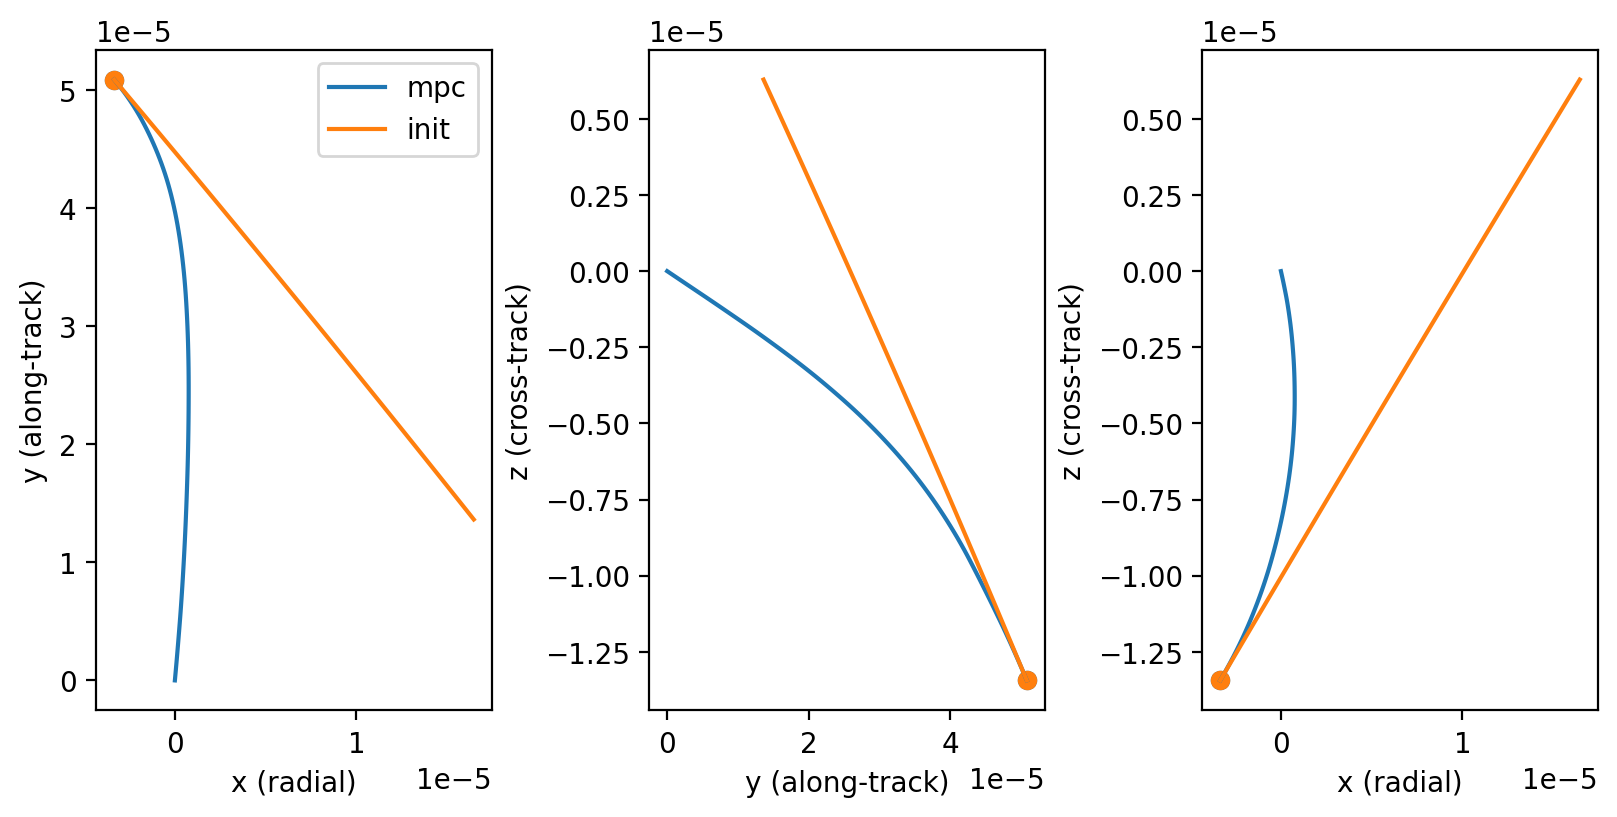

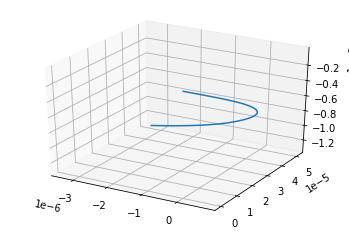

In [13]:
# Plot trajectory
ct.plot_control_trajectory2(s_optimal, s_init)